<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/analysis/News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 12.9 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


**News Crawler**

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import html

class News:
  def __init__(self):
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_ranking(self, page=1, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = list(range(1,page+1))
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=RANK&date=' + date + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")

      div = bs_obj.find_all('div', {'class':'hotNewsList'})
      li+=[html.unescape(x['href']) for x in div[0].find_all('a')]
    return li

  def get_main(self, date='1'):
    date = str(datetime.datetime.now().date().strftime("%Y-%m-%d")) if date == '1' else date
    url = 'https://finance.naver.com/news/mainnews.nhn'
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    return [x.find_all('a')[0]['href'] for x in bs_obj.find_all('dd', {'class':'articleSubject'})]

  # 시황 전망: 401
  # 기업 종목분석: 402
  # 해외 증시: 403
  # 채권 선물: 404
  # 공시 메모: 406
  # 환율: 429
  def get_focus(self, page=1, code=402, date='1', ):
    date = str(datetime.datetime.now().date().strftime("%Y%m%d")) if date == '1' else date
    pages = range(0,page)
    li = []
    for page in pages:
      url = 'https://finance.naver.com/news/news_list.nhn?mode=LSS3D&section_id=101&section_id2=258&section_id3='\
      + str(code) +  '&date=' + str(date) + '&page=' + str(page)
      result = requests.get(url, headers = self.headers)
      bs_obj = BeautifulSoup(result.content, "html.parser")
      temp = [html.unescape(x.find_all('a')[0]['href']) for x in bs_obj.find_all('dd', {'class':'articleSubject'})]
      # 업데이트 가능
      li+=[x.replace('§', '&sect') for x in temp]
    return li

  def get_article(self, url):
    url = 'https://finance.naver.com/' + url
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    title = ' '.join(bs_obj.find_all('div', {'class': 'article_info'})[0].find_all('h3')[0].get_text().split())
    context = bs_obj.find_all('div', {'class': 'articleCont'})[0]
    try:
      subheading = context.find_all('strong')[0].get_text()
    except:
      subheading = ''
    t = ' '.join(context.get_text().split())
    text = t[:t.find('@')]
    text = text.replace(subheading, '')
    return title, subheading, text

In [3]:
from multiprocessing import Pool

news = News()
news_list = news.get_ranking(4)
with Pool(30) as p:
    li = p.map(news.get_article, news_list)
li = np.array(li)

dic = {'Title':li[:,0], 'Subheading':li[:,1], 'Text':li[:,2]}
df = pd.DataFrame.from_dict(dic)
df

,Title,Subheading,Text
0,"[특징주]파인텍, 2차전지 기술 개발·매출 급증…삼성SDI 1조 투자 수혜",,"파인텍이 강세다. 폴더블 유기발광다이오드(OLED)와 2차전지, 가상현실(VR) 관..."
1,국제유가 또 82달러 육박…뉴욕증시 장중 약세 압력,"뉴욕 증시 3대 지수, 인플레 압력에 약세 흐름IMF ""인플레 압력 크다면 통화 긴...",(사진=로이터/연합뉴스 제공)[뉴욕=이데일리 김정남 특파원] 미국 뉴욕 증시가 12...
2,"[특징주] 대주전자재료, 800억 규모 투자 유치 소식에 13%↑",,대주전자재료가 LG화학이 참여한 펀드에서 800억 규모의 투자를 유치했다는 소식에 ...
3,기업들 회계기준 위반 심각…당기손익·자기자본 왜곡,금감원 조사서 최근 5년간 대상 업체 90.8% 위반 지적받아35개사 관계자 검찰 ...,금융감독원[촬영 이충원](서울=연합뉴스) 심재훈 기자 = 최근 5년간 상장회사 등 ...
4,"다시 뛰는 비트코인, ETF 투자 '가시권'",,비트코인 가격이 다시 급등하는 가운데 세계 최대 ETF(상장지수펀드) 시장인 미국에...
...,...,...,...
95,[주요경제지표] 2021년 10월 12일자,,[주요경제지표] 2021년 10월 12일자조선일보 관련뉴스해당 언론사에서 선정하며 ...
96,[e공시 눈에 띄네] 코스피-12일,,< 장 마감 후 주요 공시 >◆조선내화 = 포스코와 핵심 양소 에코 내화물 등 기타...
97,"[특징주] 한국유니온제약, 자사주 20만주 취득 소식에 4%↑",,한국유니온제약이 자사주 취득에 나선다는 소식에 상승세다. 13일 오후 1시 4분 한...
98,"NH證 ""제일기획, 배당 매력과 M&A; 모멘텀에 주목""",,[서울=뉴시스]신항섭 기자 = NH투자증권은 13일 제일기획에 대해 배당 매력과 인...


In [4]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2021-10-13 05:43:48--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c07::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M   233MB/s    in 0.5s    

2021-10-13 05:43:49 (233 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Th

In [5]:
# https://wikidocs.net/22530
from konlpy.tag import Hannanum
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class Analyser:
  def __init__(self, df):
    self.df = df

  def get_tokenized(self, text):
    hannanum = Hannanum()
    return hannanum.morphs(text) 

  def get_cleaned(self, text):
    text = ([x for x in text if len(x) > 1])
    d = {i:text.count(i) for i in set(text) if text.count(i) > 1}
    words = ' '.join(d.keys())
    return words

  def get_wordcloud(self, words):
    stop_words = ['있다', '기자', '다만', '등의', '것으로', '기대감', '기대감에', '특징주', '실적', '기대', '최대', '신영', '순매수', '상위종목', '6월', '2일', '마감', \
                  '코스닥', '규모', '기관', '외국인', '결정', '증시', '3일', '코스피', '급등', '개인', '신영증권']
    wordcloud = WordCloud(stopwords = stop_words, \
                          font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                          background_color='white', \
                          width=1200, height=800).generate(words)
    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [6]:
analyser = Analyser(df)

In [7]:
li = []

for i in range(5):
  words = analyser.get_tokenized(analyser.df['Text'][i])
  words = analyser.get_cleaned(words)
  words = words.split()
  li += words

(-0.5, 1199.5, 799.5, -0.5)

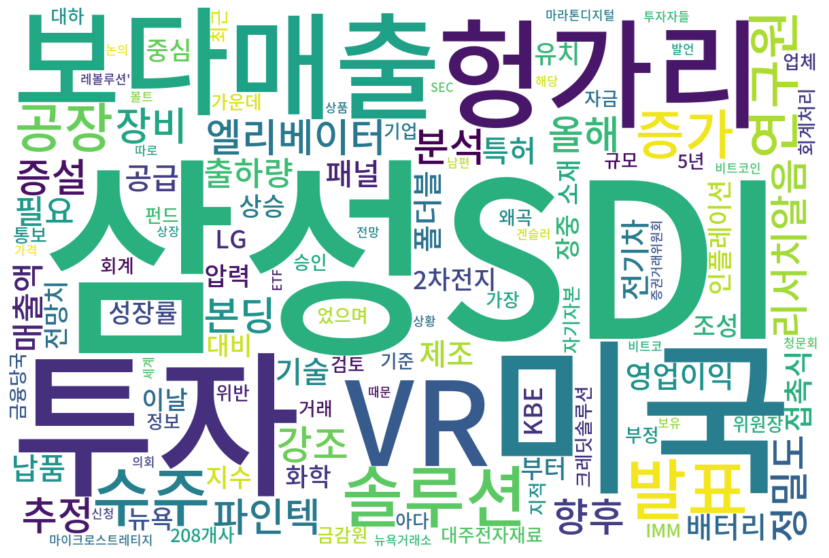

In [9]:
from konlpy.tag import Hannanum
# 정제/정규화

text = ' '.join(li)
stop_words = ['있다', '기자', '다만', '등의', '것으로', '기대감', '기대감에', '특징주', '실적', '기대', '최대', '신영', '순매수', '상위종목', '6월', '2일', '마감', \
              'ㄴ다', 'ㄴ다는', '기관', '외국인', '결정', '증시', '까지', '코스피', '었던', '하고', '으로', '따르', '었지만', '보이', '위하', '었다', '에서', '언론사']
wordcloud = WordCloud(stopwords = stop_words, \
                      font_path='/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf', \
                      background_color='white', \
                      width=1200, height=800).generate(text)
plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")